# **Section 1: Data Analysis**

In the first section, we create a dataset of the RGB values of each pixel of the base image we want to compress. This section will help analyz and visualize the following:
- **Color Distribution:** Distribution of colors in the dataset by examining the frequency or percentage of different color values (red, green, and blue) present in the image.
- **Color Channel Analysis:** Analyzing each color channel (red, green, blue) separately to understand the contribution of each channel to the overall color appearance in the image.
- **Color Histogram:** Creating a color histogram to visualize the distribution of color intensities in the dataset. This can help identify dominant colors or color ranges present in the image.

# Step 1: Importing the necessary libraries

In [23]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

# Step 2: Getting the Dataset and Assigning Variables

In this step, we load the base image that we wanted to compress and use a combination of `pandas` and the `Image` from `Pillow` to create a dataset. We also assign its `width` and `height` to store details about the image size and load the RGB data of each pixel of the base image into a NumPy array to fit into a KMeans cluster model in the next section.

In [24]:
# Read the image
colourImg = Image.open(f"images/base.jpg")

# Convert the image to a NumPy array of pixels
colourPixels = colourImg.convert("RGB")
colourArray = np.array(colourPixels.getdata())

# Convert the NumPy array to a DataFrame
df = pd.DataFrame(colourArray, columns=["red","green","blue"])

# Save the DataFrame to a txt file to be used as a dataset
np.savetxt('datasetRGB.txt', df.values, fmt='%d')


data = np.loadtxt('datasetRGB.txt')  # Load the RGB pixel data from the file into a NumPy array
im = Image.open(f"images/base.jpg")
print(im.size)
width, height = im.size # Get the width and height of the image

(256, 192)


# Step 3: Analyzing Color Distribution:

We can analyze the color distribution in the image by creating a simple barplot as follows.

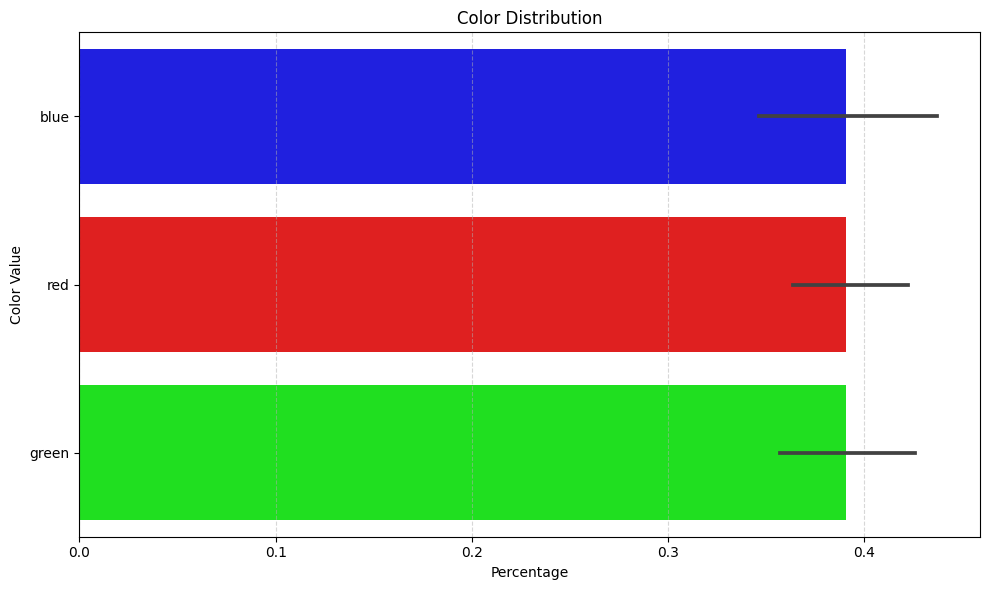

In [25]:
# Calculating the frequency of different color values
color_counts = df.apply(pd.Series.value_counts)

# Calculating the percentage of different color values
color_percentages = color_counts / len(df) * 100

# Reshaping the DataFrame for plotting
color_percentages = color_percentages.reset_index().melt('index', var_name='Color', value_name='Percentage')

# Sorting the color percentages in descending order
sorted_percentages = color_percentages.sort_values(by='Percentage', ascending=False)

# Custom color palette
color_palette = {
    'red': '#FF0000',
    'green': '#00FF00',
    'blue': '#0000FF'
}

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_percentages, x='Percentage', y='Color', palette=color_palette)
plt.xlabel('Percentage')
plt.ylabel('Color Value')
plt.title('Color Distribution')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Step 4: Analyzing each Color Channel with the help of Color Histograms

To analyze each color channel, we can compare the frequency of RGB values between 0 and 255 to gauge the following:
- Channel intensity: By examining the distribution of each pixel value in each channel, we can gain insights into the brightness or darkness of each color componenet within the image.
- Color Saturation: By analyzing the distribution of pixel values in each channel, we can assess the richness or saturation of specific colors and also assess the overall vibrancy of the image.
- Color Relationships: By comparing the pixel value distributions across channels, we can identify patterns or correlations between colors and better understand possible major color combinations and most used color harmonies within the image.

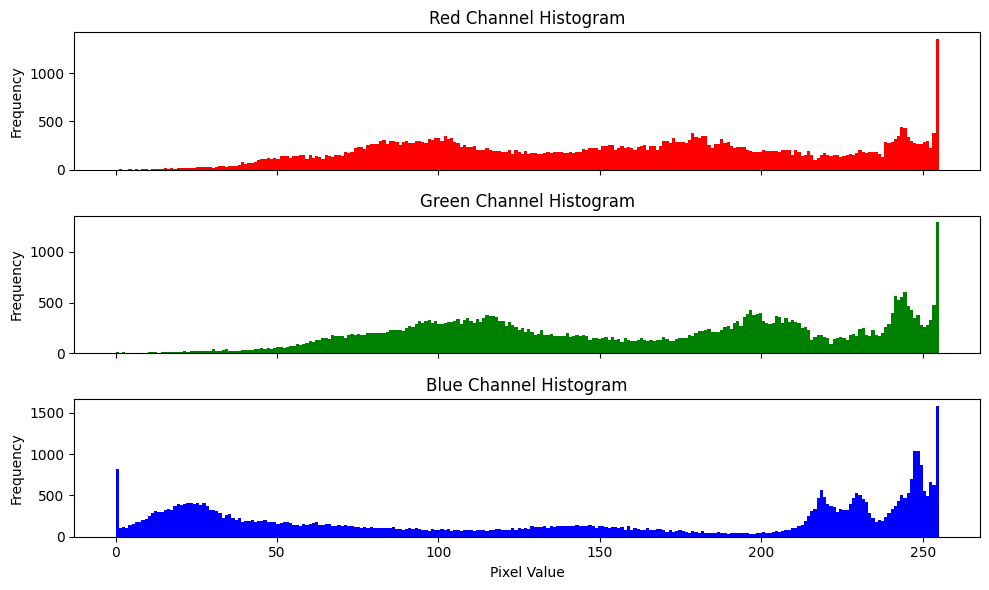

In [26]:
# Plotting the color histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Red channel histogram
axes[0].hist(df['red'], bins=256, color='red')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Red Channel Histogram')

# Green channel histogram
axes[1].hist(df['green'], bins=256, color='green')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Green Channel Histogram')

# Blue channel histogram
axes[2].hist(df['blue'], bins=256, color='blue')
axes[2].set_xlabel('Pixel Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Blue Channel Histogram')

plt.tight_layout()
plt.show()

# **Section 2: Machine Learning**

The second section of this notebook consists of the logic behind the working of the algorithm that will help us compress images using the `KMeans` library from `sklearn`.

# Modelling

In this step, we use the in-built `KMeans` library algorithm to create KMeans clusters to compress our image by `clustering the RGB values` from the  dataset we created earlier. The number of clusters, or ***`k`***, can also be considered to be the `number of colors`. To explain it simply, consider that our base image (the image we want to compress) has ***`n`*** colors. Now, by assigning a value to ***`k`***, we are reducing the ***`n`*** colors to ***`k`*** colors with the help of clustering. A higher value of ***`k`*** will lead to a better quality image and a lower loss of colors. However, it will also lead to a smaller difference between the sizes of the actual and the compressed images. In the next section of this notebook, there are a few examples demonstrating the same concept.

In [27]:
k = 16  # Number of clusters for compression
kmeans = KMeans(n_clusters=k, random_state=0)  # Create a KMeans object
kmeans.fit(data)  # Perform K-means clustering

c:\Users\Advay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=16, random_state=0)

# Output the Compressed Image

Now that we have formed our clusters, we get the `cluster labels` for each of the pixels and then proceed to compress the image by `replacing each pixel with the centroid of the cluster it was assigned to`. We then reshape the compressed data that now consists of replaced pixels, so that it equals the size of our base image. We then convert each of the data values into an `8-bit unsigned integer` as it ranges from 0 to 255, and is often used to represent the respective RGB color channels. Finally, we use `Pillow` once more to convert our data into an Image object and can now output in a format that fits our needs.

In [28]:
labels = kmeans.labels_  # Get the cluster labels for each pixel
compressed_data = kmeans.cluster_centers_[labels]  # Replace pixel values with centroid values

# Reshape the compressed image to match the original image
compressed_image = np.reshape(compressed_data, (height, width, 3))

# Convert the NumPy array to an image
compressed_image = compressed_image.astype(np.uint8) 
compressed_image = Image.fromarray(compressed_image)  # Create a PIL Image object

# Save the image as jpg in the current directory
compressed_image.save(f'images/compressed_image.jpg')

# ***Function to Call the Algorithm***

In [29]:
def compress_image(image_path, k):
    # Read the image
    colourImg = Image.open(image_path)

    # Convert the image to a NumPy array of pixels
    colourPixels = colourImg.convert("RGB")
    colourArray = np.array(colourPixels.getdata())

    # Convert the NumPy array to a DataFrame
    df = pd.DataFrame(colourArray, columns=["red", "green", "blue"])

    # Save the DataFrame to a txt file to be used as a dataset
    np.savetxt('datasetRGB.txt', df.values, fmt='%d')

    data = np.loadtxt('datasetRGB.txt')  # Load the RGB pixel data from the file into a NumPy array

    width, height = colourImg.size  # Get the width and height of the image

    kmeans = KMeans(n_clusters=k, random_state=0)  # Create a KMeans object
    kmeans.fit(data)  # Perform K-means clustering

    labels = kmeans.labels_  # Get the cluster labels for each pixel
    compressed_data = kmeans.cluster_centers_[labels]  # Replace pixel values with centroid values

    # Reshape the compressed image to match the original image
    compressed_image = np.reshape(compressed_data, (height, width, 3))

    # Convert the NumPy array to an image
    compressed_image = compressed_image.astype(np.uint8)
    compressed_image = Image.fromarray(compressed_image)  # Create a PIL Image object

    # Save the compressed image to calculate file size
    compressed_image_path = f"images/compressed_image_{k}.jpg"
    compressed_image.save(compressed_image_path)

    # Calculate file size of the compressed image in KB
    file_size_kb = os.path.getsize(compressed_image_path) / 1024

    return compressed_image, file_size_kb

# **Section 3: Examples of Compression**

In the third section of the notebook, the function is tested on a few example images to see how changing the number of clusters affects the compressed image.

c:\Users\Advay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Advay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Advay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Advay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

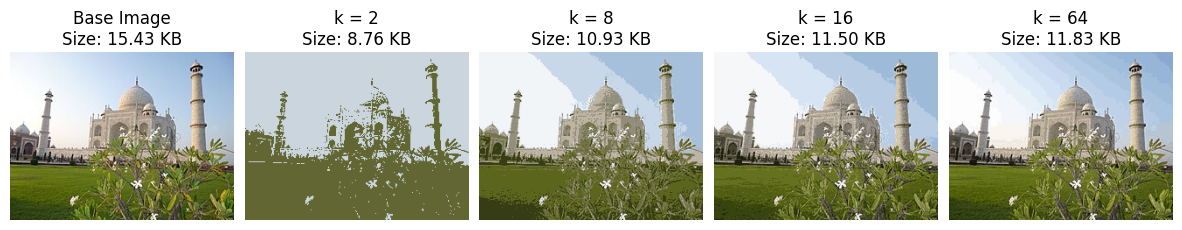

In [34]:
base_image_path = f"images/base.jpg"
num_clusters = [2, 8, 16, 64]

# Displaying base and compressed images side by side
fig, axs = plt.subplots(1, len(num_clusters) + 1, figsize=(15, 5))
plt.subplots_adjust(wspace=0.05)

#Displaying base image
base_image = Image.open(base_image_path)
axs[0].imshow(base_image)
axs[0].set_title(f"Base Image\nSize: {os.path.getsize(base_image_path) / 1024:.2f} KB")
axs[0].axis("off")

# Display the compressed images for different numbers of clusters
for i, k in enumerate(num_clusters):
    compressed_image, file_size_kb = compress_image(base_image_path, k)
    axs[i+1].imshow(compressed_image)
    axs[i+1].set_title(f"k = {k}\nSize: {file_size_kb:.2f} KB")
    axs[i+1].axis("off")

plt.show()

As we can see from the above example, as the number of clusters increases, so does the quality of the image and the size. 